In [1]:
!pip install pydub

import numpy as np
import pandas as pd
import glob
from pydub import AudioSegment

from google.colab import drive
drive.mount('/content/drive')

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential

from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

Mounted at /content/drive


In [2]:
data = {      'emotion': [],
              'age': [],
              'word': [],
              'path': [],
        }
df = pd.DataFrame(data=data)
 
start_age_index = 62
start_word_index = 71
end_word_index = 5
age_size = 3
for foldr in glob.glob(r'/content/drive/MyDrive/TESS Toronto emotional speech set data/*'):
  # print(foldr)
  age = foldr[start_age_index:(start_age_index+age_size)]
  emotion = foldr[(start_age_index+age_size+1):].lower()
  emotion_size = len(emotion)
  if (emotion == "pleasant_surprise"):
    emotion_size2 = 2
  else :
    emotion_size2 = emotion_size
  for file_name in glob.glob(foldr+'/*'):
    # print(file_name)
    word = file_name[(start_word_index+emotion_size):-(end_word_index+emotion_size2)]
    df = df.append(pd.Series([emotion, age, word, file_name], index = df.columns), ignore_index=True)
df

,emotion,age,word,path
0,fear,YAF,boat,/content/drive/MyDrive/TESS Toronto emotional ...
1,fear,YAF,door,/content/drive/MyDrive/TESS Toronto emotional ...
2,fear,YAF,base,/content/drive/MyDrive/TESS Toronto emotional ...
3,fear,YAF,fail,/content/drive/MyDrive/TESS Toronto emotional ...
4,fear,YAF,dog,/content/drive/MyDrive/TESS Toronto emotional ...
...,...,...,...,...
2795,sad,OAF,shout,/content/drive/MyDrive/TESS Toronto emotional ...
2796,sad,OAF,search,/content/drive/MyDrive/TESS Toronto emotional ...
2797,sad,OAF,turn,/content/drive/MyDrive/TESS Toronto emotional ...
2798,sad,OAF,said,/content/drive/MyDrive/TESS Toronto emotional ...


In [3]:
df0 = df.copy()

max_length = 145172
zero_signal = np.zeros(max_length)

def get_signal(file_name):
    signal = zero_signal.copy()
    temp_signal = AudioSegment.from_file(file_name)
    temp_signal = np.array(temp_signal.get_array_of_samples())
    signal_size = temp_signal.size
    signal[:signal_size] = temp_signal
    return signal
df0['signal'] = df0.apply(lambda x: get_signal(x.path), axis=1)

df0 = df0.drop("path", axis=1)

df0['emotion'] = pd.factorize(df0['emotion'])[0]
df0['age'] = pd.factorize(df0['age'])[0]
df0['word'] = pd.factorize(df0['word'])[0] 

from scipy import signal
sample_rate = 24414
df0["spectrogram"] = df0["signal"].apply(lambda x: signal.spectrogram(x, sample_rate)[2])
del max_length, zero_signal, signal, sample_rate, df
df0.head()

,emotion,age,word,signal,spectrogram
0,0,0,0,"[1.0, -7.0, -5.0, -19.0, -5.0, -9.0, -10.0, -3...","[[0.01363698373069844, 0.0013370595595961988, ..."
1,0,0,1,"[4.0, 10.0, 4.0, 9.0, 10.0, 11.0, 14.0, 11.0, ...","[[0.002735955422796827, 0.008905613503153229, ..."
2,0,0,2,"[2.0, 2.0, -27.0, -1.0, -24.0, -19.0, -6.0, -9...","[[0.05522940238613436, 0.016889906784899253, 0..."
3,0,0,3,"[-3.0, -4.0, -8.0, -5.0, -1.0, -9.0, -11.0, -8...","[[0.08350087992224602, 0.051509937951149484, 0..."
4,0,0,4,"[0.0, -6.0, -6.0, -4.0, -15.0, -24.0, -11.0, -...","[[0.001120991867091304, 0.002038129456855195, ..."


In [4]:
def get_spectrogram_mat(df):
    mat = np.zeros((df.shape[0], 44646))
    mat[:, 0] = np.array(df.age)
    mat[:, 1] = np.array(df.emotion)
    mat[:, 2] = np.array(df.word)
    for i in range(df.shape[0]):
        mat[i, 3:] = df.spectrogram.iloc[i][:-60].reshape(44643)
    return mat

In [5]:
temp_mat = get_spectrogram_mat(df0)
temp_X = temp_mat[:,1:]
temp_Y = temp_mat[:,0]

pca = PCA(n_components=1000).fit(temp_X)
X_transform = pca.transform(temp_X)
X_train, X_test, y_train, y_test = train_test_split(X_transform, temp_Y, test_size=0.2, random_state=1)

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(1, X_transform.shape[1])),
    tf.keras.layers.LayerNormalization(axis=-1, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(800, activation='relu'),
    tf.keras.layers.Dense(7)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.09, nesterov=True, name='SGD',),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, ),
              metrics=['accuracy'])

mc = tf.keras.callbacks.ModelCheckpoint('best_model', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[mc]) # es, 
saved_model = tf.keras.models.load_model('best_model')

Epoch 1/20
70/70 [==============================] - 2s 27ms/step - loss: 0.3096 - accuracy: 0.8839 - val_loss: 0.1334 - val_accuracy: 0.9607

Epoch 00001: val_accuracy improved from -inf to 0.96071, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets
Epoch 2/20
70/70 [==============================] - 2s 25ms/step - loss: 0.1037 - accuracy: 0.9728 - val_loss: 0.0841 - val_accuracy: 0.9714

Epoch 00002: val_accuracy improved from 0.96071 to 0.97143, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets
Epoch 3/20
70/70 [==============================] - 2s 25ms/step - loss: 0.0651 - accuracy: 0.9839 - val_loss: 0.0642 - val_accuracy: 0.9857

Epoch 00003: val_accuracy improved from 0.97143 to 0.98571, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets
Epoch 4/20
70/70 [==============================] - 2s 25ms/step - loss: 0.0453 - accuracy: 0.9942 - val_loss: 0.0525 - val_accuracy: 0.9875

Epoch 00004: va

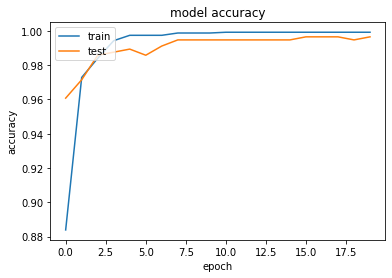

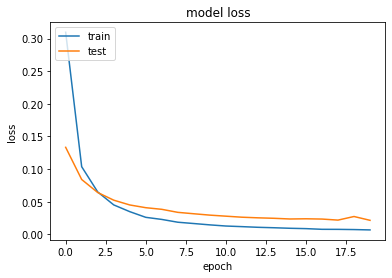

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
y_pred = model.predict_classes(X_test)
target_names = ['YAF', 'OAF']
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_pred, y_test))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

         YAF       1.00      1.00      1.00       275
         OAF       1.00      1.00      1.00       285

    accuracy                           1.00       560
   macro avg       1.00      1.00      1.00       560
weighted avg       1.00      1.00      1.00       560

[[274   1]
 [  1 284]]
